In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image
from tqdm import tqdm
from PIL import Image
import os
import csv
import shutil


In [4]:
!pip list | grep -e fastai -e torch -e torchvision

fastai                                 2.7.12
pytorch-ignite                         0.4.11
pytorch-lightning                      2.0.1.post0
torch                                  2.0.0
torchaudio                             2.0.1
torchdata                              0.6.0
torchinfo                              1.7.2
torchmetrics                           0.11.4
torchtext                              0.15.1
torchvision                            0.15.1


In [2]:


# Define the paths to the CSV file and image directory
csv_file = '/kaggle/input/isic25kgt/ISIC_2019_Training_GroundTruth.csv'
image_dir = '/kaggle/input/isicdataset2019/ISIC_2019_Training_Input'

# Define the paths to the output directories
output_dir = '/kaggle/working/train/'

# Create the output directories if they don't exist
os.makedirs(output_dir, exist_ok=True)

# Read the CSV file and get the label column names
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    header = next(reader)  # Get the header row
    label_cols = header[1:]  # Get the label column names

# Create a directory for each label column
label_dirs = [os.path.join(output_dir, col) for col in label_cols]
for label_dir in label_dirs:
    os.makedirs(label_dir, exist_ok=True)

# Iterate over the rows of the CSV file and copy the images to the appropriate label folder
with open(csv_file, 'r') as f:
    reader = csv.reader(f)
    next(reader)  # Skip the header row
    for row in reader:
        image_name = row[0]  # Get the image filename
        labels = row[1:]  # Get the label values
       
        # Add the file extension
        image_name_with_extension = image_name + '.jpg'

        # Copy the image to the appropriate label directory
        for i, label in enumerate(labels):
            if label == '1.0':
                label_dir = label_dirs[i]
                src_path = os.path.join(image_dir, image_name_with_extension)
                dst_path = os.path.join(label_dir, image_name_with_extension)
                shutil.copy(src_path, dst_path)

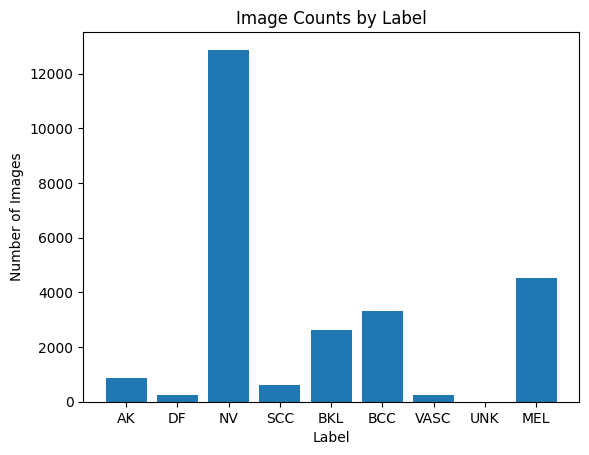

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the output directory
output_dir = '/kaggle/working/train/'

label_list = ['UNK', 'AK', 'DF', 'MEL', 'NV', 'VASC', 'BCC', 'BKL', 'SCC']

# Get a list of the label directories that match the label list
label_dirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and d in label_list]

# Iterate over the label directories and count the number of images in each directory
counts = []
labels = []
for label_dir in label_dirs:
    num_images = len(os.listdir(label_dir))
    counts.append(num_images)
    labels.append(os.path.basename(label_dir))

# Create a bar chart of the image counts by label
plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Image Counts by Label')
plt.show()

In [7]:
import os
labels = os.listdir("train")
print("No. of labels: {}".format(len(labels)))
print("-----------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir("train/"+label))))

No. of labels: 9
-----------------
AK, 867 files
DF, 239 files
NV, 12875 files
SCC, 628 files
BKL, 2624 files
BCC, 3323 files
VASC, 253 files
UNK, 0 files
MEL, 4522 files


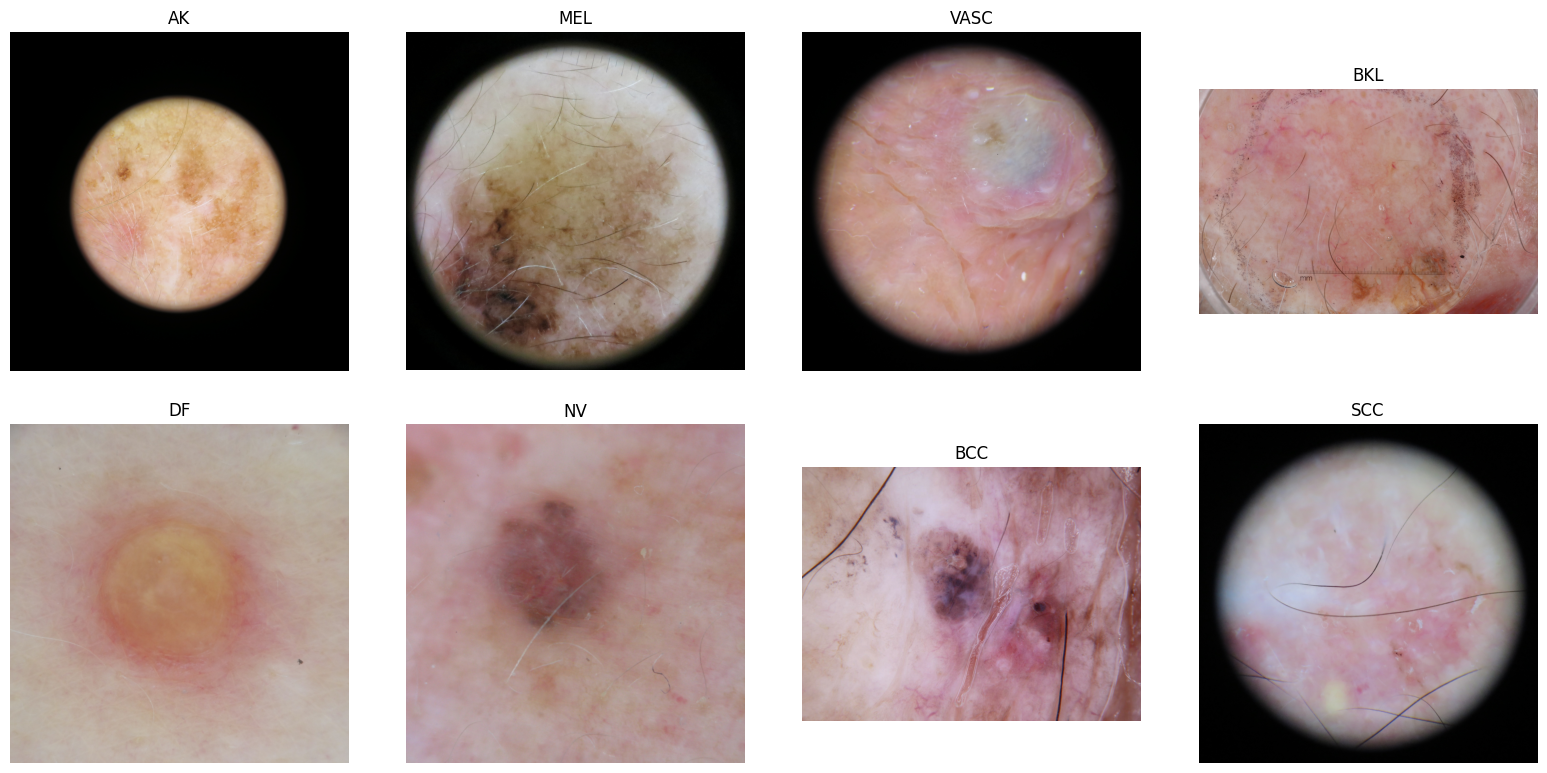

In [19]:

# Define the label names
labels = ['AK', 'DF', 'MEL', 'NV', 'VASC', 'BCC', 'BKL', 'SCC']

# Define the path to the image directories
image_dir = '/kaggle/working/train'

# Create the subplots
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.tight_layout()

# Select one random image from each directory and display them in subplots
for i, label in enumerate(labels):
    # Get a list of the image filenames in the current directory
    image_names = os.listdir(os.path.join(image_dir, label))

    # Select a random image from the directory
    selected_image = np.random.choice(image_names, size=1)

    # Display the selected image in a separate subplot
    # Note: we use integer division to calculate the row and col indices
    row_idx = i% 2
    col_idx = i// 2
    im = Image.open(os.path.join(image_dir, label, selected_image[0]))
    ax[row_idx, col_idx].imshow(im)
    ax[row_idx, col_idx].set_title(label)
    ax[row_idx, col_idx].axis('off')

# Show the plot
plt.show()

In [12]:
data = pd.read_csv('/kaggle/input/groundtable/ISIC_2019_Training_GroundTruth.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/groundtable/ISIC_2019_Training_GroundTruth.csv'

In [4]:
store_list = []
image_height = 224
image_width = 224
for i in tqdm(range(data.shape[0])):
    path = '/kaggle/input/isicdataset2019/ISIC_2019_Training_Input/' + data['image'][i] + '.jpg'
    image_check = image.load_img(path, target_size=(image_height, image_width))
    image_check = image.img_to_array(image_check)
    # scaling the images
    image_check = image_check/255
    store_list.append(image_check)

x = np.array(store_list)
y = data.drop(columns=['image'])
Y = y.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=42, test_size=0.20)

100%|██████████| 1000/1000 [00:16<00:00, 59.02it/s]


In [5]:
# Define the model architecture
input_layer = keras.layers.Input(shape=x_train[0].shape)

# First Inception module
conv1 = Conv2D(64, (1,1), padding='same', activation='relu')(input_layer)
conv2 = Conv2D(96, (1,1), padding='same', activation='relu')(input_layer)
conv2 = Conv2D(128, (3,3), padding='same', activation='relu')(conv2)
conv3 = Conv2D(16, (1,1), padding='same', activation='relu')(input_layer)
conv3 = Conv2D(32, (5,5), padding='same', activation='relu')(conv3)
pool = MaxPool2D((3,3), strides=(1,1), padding='same')(input_layer)
pool = Conv2D(32, (1,1), padding='same', activation='relu')(pool)
output1 = concatenate([conv1, conv2, conv3, pool], axis=-1)

# Second Inception module
conv1 = Conv2D(128, (1,1), padding='same', activation='relu')(output1)
conv2 = Conv2D(128, (1,1), padding='same', activation='relu')(output1)
conv2 = Conv2D(192, (3,3), padding='same', activation='relu')(conv2)
conv3 = Conv2D(32, (1,1), padding='same', activation='relu')(output1)
conv3 = Conv2D(96, (5,5), padding='same', activation='relu')(conv3)
pool = MaxPool2D((3,3), strides=(1,1), padding='same')(output1)
pool = Conv2D(64, (1,1), padding='same', activation='relu')(pool)
output2 = concatenate([conv1, conv2, conv3, pool], axis=-1)

# Third Inception module
conv1 = Conv2D(192, (1,1), padding='same', activation='relu')(output2)
conv2 = Conv2D(96, (1,1), padding='same', activation='relu')(output2)
conv2 = Conv2D(208, (3,3), padding='same', activation='relu')(conv2)
conv3 = Conv2D(16, (1,1), padding='same', activation='relu')(output2)
conv3 = Conv2D(48, (5,5), padding='same', activation='relu')(conv3)
pool = MaxPool2D((3,3), strides=(1,1), padding='same')(output2)
pool = Conv2D(64, (1,1), padding='same', activation='relu')(pool)
output3 = concatenate([conv1, conv2, conv3, pool], axis=-1)

# Fourth Inception module
conv1 = Conv2D(160, (1,1), padding='same', activation='relu')(output3)
conv2 = Conv2D(112, (1,1), padding='same', activation='relu')(output3)
conv2 = Conv2D(224, (3,3), padding='same', activation='relu')(conv2)
conv3 = Conv2D(24, (1,1), padding='same', activation='relu')(output3)
conv3 = Conv2D(64, (5,5), padding='same', activation='relu')(conv3)
pool = MaxPool2D((3,3), strides=(1,1), padding='same')(output3)
pool = Conv2D(64, (1,1), padding='same', activation='relu')(pool)
output4 = concatenate([conv1, conv2, conv3, pool], axis=-1)

# Fifth Inception module
conv1 = Conv2D(128, (1,1), padding='same', activation='relu')(output4)
conv2 = Conv2D(128, (1,1), padding='same', activation='relu')(output4)
conv2 = Conv2D(256, (3,3), padding='same', activation='relu')(conv2)
conv3 = Conv2D(24, (1,1), padding='same', activation='relu')(output4)
conv3 = Conv2D(64, (5,5), padding='same', activation='relu')(conv3)
pool = MaxPool2D((3,3), strides=(1,1), padding='same')(output4)
pool = Conv2D(64, (1,1), padding='same', activation='relu')(pool)
output5 = concatenate([conv1, conv2, conv3, pool], axis=-1)

# Average pooling and output layer
pool = AveragePooling2D((7,7))(output5)
flatten = Flatten()(pool)
output_layer = Dense(9, activation='sigmoid')(flatten)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 96  384         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_3 (Conv2D)              (None, 224, 224, 16  64          ['input_1[0][0]']                
                                )                                                             

In [6]:
model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
es_callback = keras.callbacks.EarlyStopping(patience=3)
history = model.fit(x_train, y_train, batch_size=1,epochs=10, validation_split=0.3, callbacks=[es_callback])
# model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
560/560 [==============================] - 90s 133ms/step - loss: 0.1821 - accuracy: 0.7393 - val_loss: 0.1132 - val_accuracy: 0.8167
Epoch 2/10
560/560 [==============================] - 72s 128ms/step - loss: 0.1416 - accuracy: 0.7643 - val_loss: 0.1077 - val_accuracy: 0.7917
Epoch 3/10
560/560 [==============================] - 72s 128ms/step - loss: 0.1289 - accuracy: 0.7571 - val_loss: 0.1169 - val_accuracy: 0.7583
Epoch 4/10
560/560 [==============================] - 74s 131ms/step - loss: 0.1360 - accuracy: 0.7732 - val_loss: 0.1464 - val_accuracy: 0.8042
Epoch 5/10
560/560 [==============================] - 74s 131ms/step - loss: 0.1318 - accuracy: 0.7893 - val_loss: 0.1082 - val_accuracy: 0.8167


Test loss: 0.10346555709838867
Test accuracy: 0.824999988079071
7/7 [==============================] - 6s 758ms/step
Actual: [0. 1. 0. 0. 0. 0. 0. 0. 0.] Predicted: [1.8494473e-01 8.1758535e-01 2.0052690e-05 2.0033538e-05 1.9797142e-05
 2.0042824e-05 1.9725961e-05 2.0264926e-05 1.9994965e-05]
Actual: [0. 1. 0. 0. 0. 0. 0. 0. 0.] Predicted: [2.3407418e-01 7.6568931e-01 2.1215824e-04 2.1231812e-04 2.1195244e-04
 2.1258998e-04 2.1201612e-04 2.1277004e-04 2.1314570e-04]
Actual: [0. 1. 0. 0. 0. 0. 0. 0. 0.] Predicted: [6.6254228e-02 9.3368345e-01 8.3208222e-05 8.3739156e-05 8.3734441e-05
 8.3711609e-05 8.3832878e-05 8.3680003e-05 8.4178537e-05]
Actual: [0. 1. 0. 0. 0. 0. 0. 0. 0.] Predicted: [1.4235969e-01 8.5888088e-01 7.0984606e-05 7.0887807e-05 7.1330396e-05
 7.1946997e-05 7.1085393e-05 7.1977396e-05 7.0972761e-05]
Actual: [1. 0. 0. 0. 0. 0. 0. 0. 0.] Predicted: [1.36560544e-01 8.62608433e-01 1.20242141e-04 1.21668854e-04
 1.21328238e-04 1.20054945e-04 1.21091070e-04 1.19700686e-04
 1.20

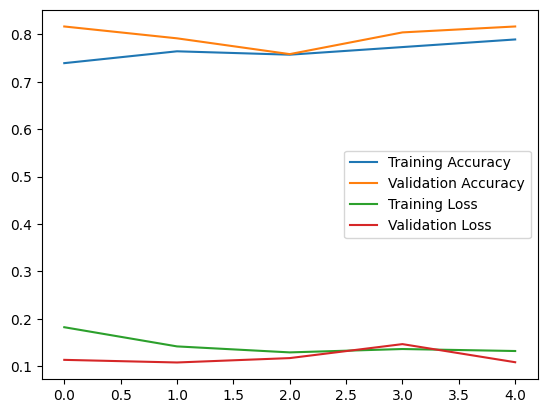

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Make predictions on the test set
y_pred = model.predict(x_test)

# Print the actual and predicted data side by side
for i in range(len(y_test)):
    print('Actual:', y_test[i], 'Predicted:', y_pred[i])

# Plot the accuracy and loss graphs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [8]:
import os

label_list = ['UNK', 'AK', 'DF', 'MEL', 'NV', 'VASC', 'BCC', 'BKL', 'SCC']
train_dir = 'train'

# Create the train directory if it does not exist
if not os.path.exists(train_dir):
    os.mkdir(train_dir)

# Create a subdirectory for each label in the label_list
for label in label_list:
    label_dir = os.path.join(train_dir, label)
    if not os.path.exists(label_dir):
        os.mkdir(label_dir)

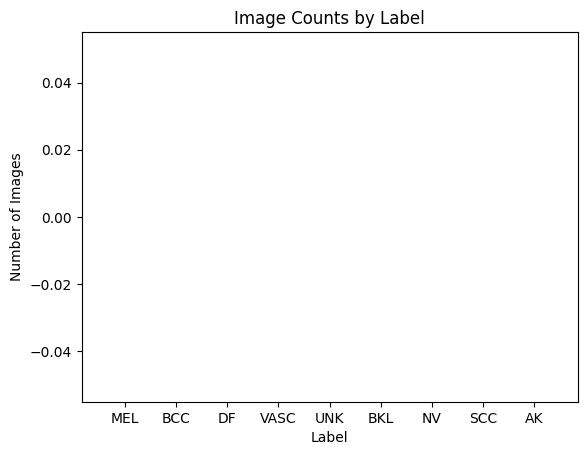

In [10]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Define the path to the output directory
output_dir = '/kaggle/working/train/'

label_list = ['UNK', 'AK', 'DF', 'MEL', 'NV', 'VASC', 'BCC', 'BKL', 'SCC']

# Get a list of the label directories that match the label list
label_dirs = [os.path.join(output_dir, d) for d in os.listdir(output_dir) if os.path.isdir(os.path.join(output_dir, d)) and d in label_list]

# Iterate over the label directories and count the number of images in each directory
counts = []
labels = []
for label_dir in label_dirs:
    num_images = len(os.listdir(label_dir))
    counts.append(num_images)
    labels.append(os.path.basename(label_dir))

# Create a bar chart of the image counts by label
plt.bar(labels, counts)
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.title('Image Counts by Label')
plt.show()